
## Assignment: Model Interpretability
**AUTHOR: AKHILESH DONGRE**



Interpreting coefficients and results of the following models:

1. Logistic Regression
2. Random Forest
3. AutoML (H2O)

Followed by Analysing the SHAP Values of the models mentioned above




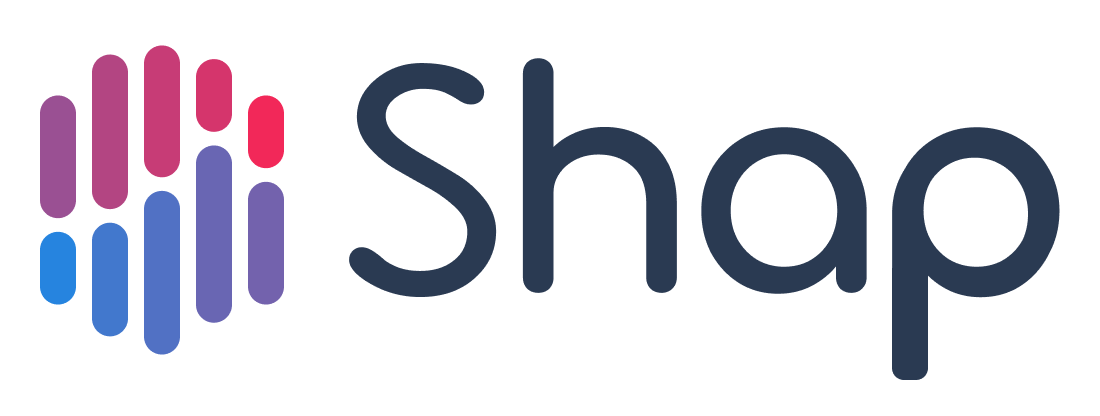

## Abstract
Brain Stroke happens when there is a blockage in the blood circulation in the brain or when a blood vessel in the brain breaks and leaks. The burst or blockage prevents blood and oxygen reaching the brain tissue. Without oxygen the tissues and cells in the brain are damaged and die in no time leading to many symptoms.

According to the World Health Organization (WHO), stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths. It is another health issue that has found to be rising throughout the world due to the adoption of lifestyle changes that disregards healthy lifestyle & good eating habits.

Based on the attributes below we predict whether a person will suffer a stroke or not.
### Dataset Attributes :
    
- **id** : unique identifier
- **gender** : "Male", "Female" or "Other"
- **age** : age of the patient
- **hypertension**: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
- **heart_disease** : 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
- **ever_married** : "No" or "Yes"
- **work_type** : "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
- **Residence_type** : "Rural" or "Urban"
- **avg_glucose_level** : average glucose level in blood
- **bmi** : body mass index
- **smoking_status** : "formerly smoked", "never smoked", "smokes" or "Unknown"*
- **stroke** : 1 if the patient had a stroke or 0 if not

The Aim is
- To classify / predict whether a patient can suffer a stroke.
- It is a **binary classification** problem with multiple numerical and categorical features.

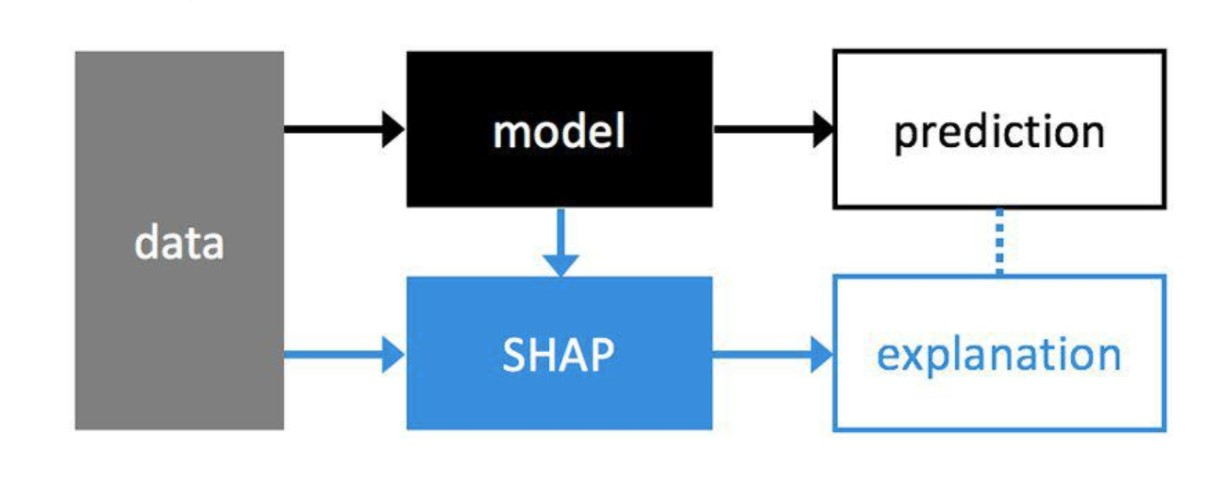

In [241]:
#@title
#Importing Libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os


import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.gridspec as grid_spec
import seaborn as sns
from imblearn.over_sampling import SMOTE
# import scikitplot as skplt


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score


from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score, f1_score
import warnings
warnings.filterwarnings('ignore')


In [242]:
df = pd.read_csv("/content/healthcare-dataset-stroke-data.csv")
df.head(3)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1


# Data Preprocessing

In [243]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

**How can we deal with blanks in our data?**

There are many ways. One can simply drop these records, fill the blanks with the mean, the median, or even simply the record before or after the missing value.

But there are other, more unusual ways. 

Here I will use a **Decision Tree to predict the missing BMI**

Other interesting methods to explore could include using K-Nearest-Neighbours to fill the gaps.

In [244]:
# Dealing with missing values using decision Tree

DT_bmi_pipe = Pipeline( steps=[ 
                               ('scale',StandardScaler()),
                               ('lr',DecisionTreeRegressor(random_state=42))
                              ])
X = df[['age','gender','bmi']].copy()
X.gender = X.gender.replace({'Male':0,'Female':1,'Other':-1}).astype(np.uint8)

Missing = X[X.bmi.isna()]
X = X[~X.bmi.isna()]
Y = X.pop('bmi')
DT_bmi_pipe.fit(X,Y)
predicted_bmi = pd.Series(DT_bmi_pipe.predict(Missing[['age','gender']]),index=Missing.index)
df.loc[Missing.index,'bmi'] = predicted_bmi

In [245]:
print('Missing values: ',sum(df.isnull().sum()))

Missing values:  0


We've **replaced all missing values**

Now we can move to the next step

## Exploring the data

We have now dealt with the missing values in the data.

Next, I want to **explore** the data.

Does age makes one more likely to suffer a stroke? What about gender? Or BMI?

These are all questions that can be explored and answered with some data visulization. 

First, let's look at the numeric/continuous variable distribtion

In [246]:
variables = [variable for variable in df.columns if variable not in ['id','stroke']]

conts = ['age','avg_glucose_level','bmi']

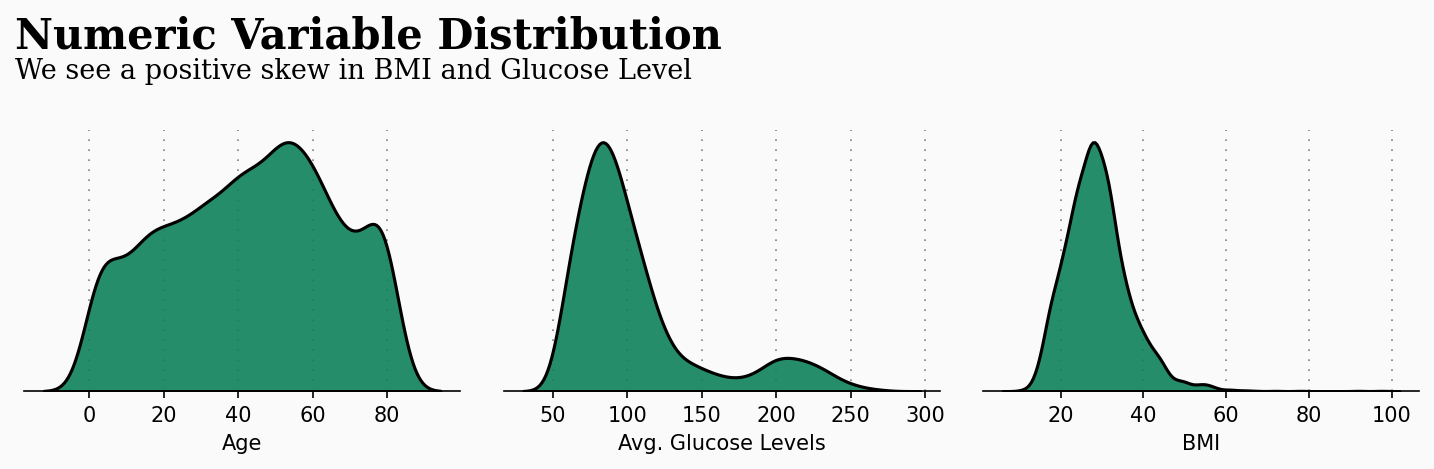

In [247]:
#@title
fig = plt.figure(figsize=(12, 12), dpi=150, facecolor='#fafafa')
gs = fig.add_gridspec(4, 3)
gs.update(wspace=0.1, hspace=0.4)

background_color = "#fafafa"

plot = 0
for row in range(0, 1):
    for col in range(0, 3):
        locals()["ax"+str(plot)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(plot)].set_facecolor(background_color)
        locals()["ax"+str(plot)].tick_params(axis='y', left=False)
        locals()["ax"+str(plot)].get_yaxis().set_visible(False)
        for s in ["top","right","left"]:
            locals()["ax"+str(plot)].spines[s].set_visible(False)
        plot += 1

plot = 0
for variable in conts:
        sns.kdeplot(df[variable] ,ax=locals()["ax"+str(plot)], color='#0f815b', shade=True, linewidth=1.5, ec='black',alpha=0.9, zorder=3, legend=False)
        locals()["ax"+str(plot)].grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1,5))
        #locals()["ax"+str(plot)].set_xlabel(variable) removed this for aesthetics
        plot += 1
        
ax0.set_xlabel('Age')
ax1.set_xlabel('Avg. Glucose Levels')
ax2.set_xlabel('BMI')


ax0.text(-20, 0.022, 'Numeric Variable Distribution', fontsize=20, fontweight='bold', fontfamily='serif')
ax0.text(-20, 0.02, 'We see a positive skew in BMI and Glucose Level', fontsize=13, fontweight='light', fontfamily='serif')

plt.show()

So we've **gained some understanding** on the distributions of our numeric variables, **but we can add more information** to this plot. 

Let's see how the distribution of our numeric variables is different for **those that have strokes, and those that do not.**

This could be important for modelling later on

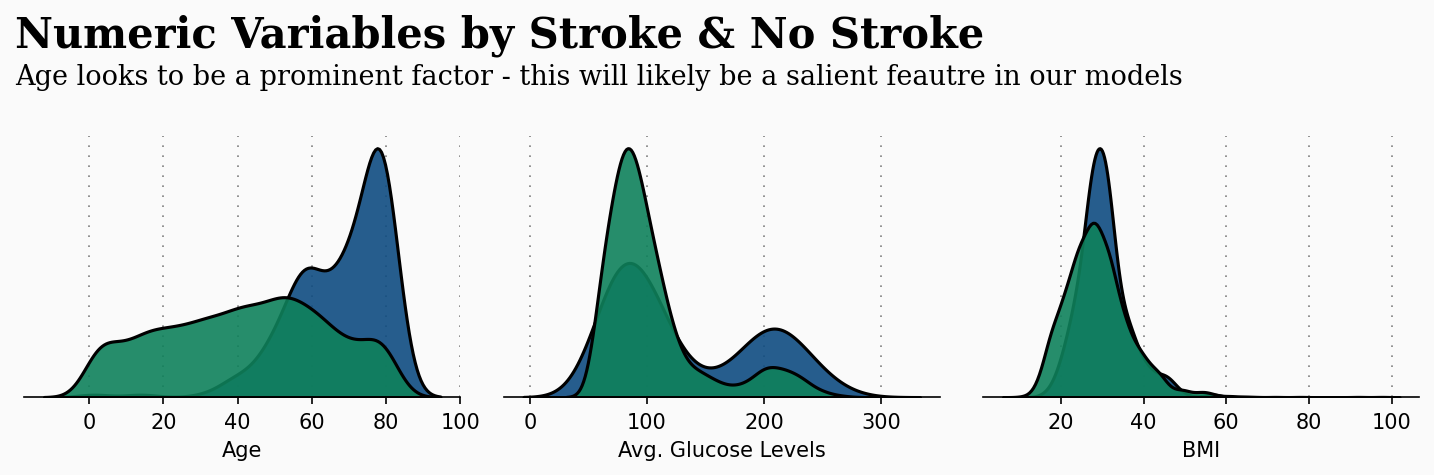

In [248]:
#@title
fig = plt.figure(figsize=(12, 12), dpi=150,facecolor=background_color)
gs = fig.add_gridspec(4, 3)
gs.update(wspace=0.1, hspace=0.4)


plot = 0
for row in range(0, 1):
    for col in range(0, 3):
        locals()["ax"+str(plot)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(plot)].set_facecolor(background_color)
        locals()["ax"+str(plot)].tick_params(axis='y', left=False)
        locals()["ax"+str(plot)].get_yaxis().set_visible(False)
        for s in ["top","right","left"]:
            locals()["ax"+str(plot)].spines[s].set_visible(False)
        plot += 1

plot = 0

s = df[df['stroke'] == 1]
ns = df[df['stroke'] == 0]

for feature in conts:
        sns.kdeplot(s[feature], ax=locals()["ax"+str(plot)], color='#0f4c81', shade=True, linewidth=1.5, ec='black',alpha=0.9, zorder=3, legend=False)
        sns.kdeplot(ns[feature],ax=locals()["ax"+str(plot)], color='#0f815b', shade=True, linewidth=1.5, ec='black',alpha=0.9, zorder=3, legend=False)
        locals()["ax"+str(plot)].grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1,5))
        #locals()["ax"+str(plot)].set_xlabel(feature)
        plot += 1

ax0.set_xlabel('Age')
ax1.set_xlabel('Avg. Glucose Levels')
ax2.set_xlabel('BMI')
        
ax0.text(-20, 0.056, 'Numeric Variables by Stroke & No Stroke', fontsize=20, fontweight='bold', fontfamily='serif')
ax0.text(-20, 0.05, 'Age looks to be a prominent factor - this will likely be a salient feautre in our models', 
         fontsize=13, fontweight='light', fontfamily='serif')

plt.show()


## Insight

Based on the above plots, it seems clear that **Age is a big factor** in stroke patients - the older you get the more at risk you are.

Though less obvious, there are also differences in Avg. Glucose Levels and BMI.


## Model preparation

In [249]:
#@title
# Encoding categorical values

df['gender'] = df['gender'].replace({'Male':0,'Female':1,'Other':-1}).astype(np.uint8)
df['Residence_type'] = df['Residence_type'].replace({'Rural':0,'Urban':1}).astype(np.uint8)
df['work_type'] = df['work_type'].replace({'Private':0,'Self-employed':1,'Govt_job':2,'children':-1,'Never_worked':-2}).astype(np.uint8)

# Modelling

# Can we predict whether or not an indiviudal will suffer a stroke?

First, I will use the SMOTE (Synthetic Minority Over-sampling Technique) to balance our dataset.

Currently, as I mentioned above, there are many more negative examples of a stroke and this could hinder our model.

This can be addressed using SMOTE.

In [250]:
X  = df[['gender','age','hypertension','heart_disease','work_type','avg_glucose_level','bmi']]
y = df['stroke']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.3, random_state=42)

In [251]:
X_test.head(2)

,gender,age,hypertension,heart_disease,work_type,avg_glucose_level,bmi
4688,0,31.0,0,0,1,64.85,23.0
4478,0,40.0,0,0,1,65.29,28.3


In [252]:
# Our data is biased, we can fix this with SMOTE

oversample = SMOTE()
X_train_resh, y_train_resh = oversample.fit_resample(X_train, y_train.ravel())

Our data is now balanced wrt to the Response variable Stroke



We will be using Logisitc Regression, Random Forest, and H2O AutoML   for this classificatioin task. 



###LOGISTIC REGRESSION

In [254]:
# Let's use those params now
# Using L2 regularization

logreg_pipeline = Pipeline(steps = [('scale',StandardScaler()),('LR',LogisticRegression(C=0.1,penalty='l2',random_state=42))])

logreg_pipeline.fit(X_train_resh,y_train_resh)

#logreg.fit(X_train_resh,y_train_resh)

logreg_tuned_pred   = logreg_pipeline.predict(X_test)

In [255]:
print(classification_report(y_test,logreg_tuned_pred))

print('Accuracy Score: ',accuracy_score(y_test,logreg_tuned_pred))
print('F1 Score: ',f1_score(y_test,logreg_tuned_pred))
print('AUC SCORE:', roc_auc_score(y_test,logreg_tuned_pred))

              precision    recall  f1-score   support

           0       0.97      0.76      0.86      3404
           1       0.12      0.61      0.20       173

    accuracy                           0.76      3577
   macro avg       0.55      0.69      0.53      3577
weighted avg       0.93      0.76      0.83      3577

Accuracy Score:  0.7576181157394465
F1 Score:  0.1964782205746061
AUC SCORE: 0.6888495683419031


In [256]:
# feature_names = logreg_pipeline[:-1].get_feature_names_out()

coefs = pd.DataFrame(
    logreg_pipeline.named_steps['LR'].coef_,
    columns=['gender','age','hypertension','heart_disease','work_type','avg_glucose_level','bmi'],
    # index=feature_names
)

coefs
# feature_names
# logreg_pipeline.named_steps['LR'].coef_ #['gender','age','hypertension','heart_disease','work_type','avg_glucose_level','bmi']

,gender,age,hypertension,heart_disease,work_type,avg_glucose_level,bmi
0,-0.805297,1.990079,-0.444081,-0.233067,-0.379363,0.105511,0.213954


###Interpreting Coefficients for logistic Regression
 The equation for probabilty p 
* logit(p) = a+ bX₁ + cX₂ ( Equation )
where p is the stroke variable 

logit(p) is log(p/1-p), where p = P{Y = 1}, i.e. the probability of “success”, or the presence of an outcome. X₁ and X₂ are the predictor variables, and b and c are their corresponding coefficients, each of which determines the emphasis X₁ and X₂ have on the final outcome Y (or p). Last, a is simply the intercept.

So, for the above values the log-likelihoods are represented by the coefficients.
From the coefficients we can infer: 
1. a 1 unit increase in age will result in  1.99 increase in logit(stroke)
2. a 1 unit increase in gender will result in  0.80 decrease in logit(stroke)
3. a 1 unit increase in hypertension will result in  0.44 decrease in logit(stroke)
4. a 1 unit increase in heart_disease will result in  0.233 decrease in logit(stroke)
5. a 1 unit increase in work_type will result in  0.37 decrease in logit(stroke)
6. a 1 unit increase in avg_glucose_level will result in 0.10 increase in logit(stroke)
7. a 1 unit increase in bmi will result in  0.213 increase in logit(stroke)

Results: 

Accuracy Score:  0.7578976796197932

F1 Score:  0.19065420560747662

AUC SCORE: 0.6780233047825408

## RANDOM FOREST 

In [119]:
# Pretty good accuracy, but poor recall!

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree


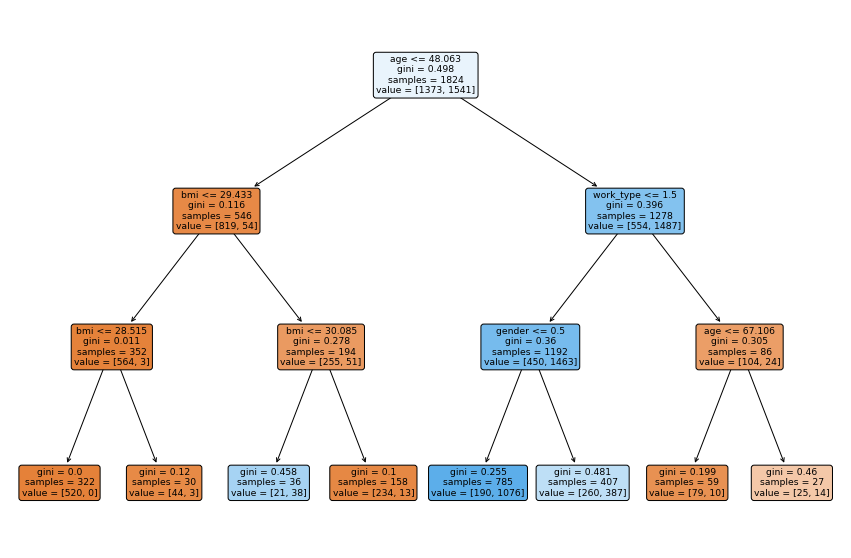

In [120]:
# Let's use those params now
rfc = RandomForestClassifier()

rfc = RandomForestClassifier(max_features=7,n_estimators=100,bootstrap=True,max_depth=3)

rfc.fit(X_train_resh,y_train_resh)

fig = plt.figure(figsize=(15, 10))
plot_tree(rfc.estimators_[0],
          feature_names=X.columns,
          # feature_names=wine.feature_names,
          # class_names=wine.target_names, 
          filled=True, impurity=True, 
          rounded=True)

rfc_tuned_pred = rfc.predict(X_test)

### Interpreting Nodels for Decision trees [extracted 0th tree]
 Decision trees are built by recursively splitting our training samples using the features from the data that work best for the specific task. This is done by evaluating certain metrics, like the Gini index or the Entropy for categorical decision trees, or the Residual or Mean Squared Error for regression trees.

So, from the nodes in the graph above are we can infer: 
1. root node age starts with [1373,1541] samples and the age < 48.063 divides the data.

2. at depth  1 for age < 48.063 the bmi divides at < 29.433 and for age > 48.063 the work_type divides for>1.5 i.e it should be govt_job

3. at depth  2 for bmi < 29.433 the bmi divides at < 28.215 and for bmi > 29.433 the bmi divides at bmi < 30.085

4. Considering the right side of the tree at depth 2 if the gender is less 0.5 i.e 0 male or if age < 67.106 eventually divides the data


Results: 

Accuracy Score:  0.7025440313111546

F1 Score:  0.18529862174578868

AUC Score: 0.7010623340103108

In [118]:
print(classification_report(y_test,rfc_tuned_pred))

print('Accuracy Score: ',accuracy_score(y_test,rfc_tuned_pred))
print('F1 Score: ',f1_score(y_test,rfc_tuned_pred))
print('AUC Score:', roc_auc_score(y_test,rfc_tuned_pred))

              precision    recall  f1-score   support

           0       0.98      0.70      0.82      3404
           1       0.11      0.70      0.19       173

    accuracy                           0.70      3577
   macro avg       0.54      0.70      0.50      3577
weighted avg       0.94      0.70      0.79      3577

Accuracy Score:  0.7025440313111546
F1 Score:  0.18529862174578868
AUC Score: 0.7010623340103108


##AutoML H2O

In [ ]:
#@title
!pip install h2o

In [ ]:
#@title
# Load the H2O library and start up the H2O cluter locally on your machine
import h2o
from h2o.automl import H2OAutoML
import re
# Number of threads, nthreads = -1, means use all cores on your machine
# max_mem_size is the maximum memory (in GB) to allocate to H2O
h2o.init(nthreads = -1, max_mem_size = 8)

In [179]:
data = h2o.H2OFrame(df.drop(columns={"id"}))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [180]:
y='stroke'
data[y] = data[y].asfactor()
# print(data[y].levels())

splits = data.split_frame(ratios=[0.7, 0.15], seed=1)  

train = splits[0]
valid = splits[1]
test = splits[2]

print ("Rows in Train",train.nrow)
print ("Rows in Validation",valid.nrow)
print ("Rows in Test",test.nrow)

Rows in Train 3598
Rows in Validation 744
Rows in Test 768


In [181]:
import h2o

from h2o.estimators.glm import H2OGeneralizedLinearEstimator
aml = H2OAutoML(max_models =10,max_runtime_secs_per_model=30,exclude_algos=['DeepLearning','DRF'],
                balance_classes=True,	seed =12)
aml.train(training_frame = train,
          y = y)

lb = aml.leaderboard
lb.head(rows=lb.nrows)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GLM_1_AutoML_3_20221206_30846,0.832706,0.161824,0.192603,0.279718,0.20863,0.0435266
StackedEnsemble_BestOfFamily_1_AutoML_3_20221206_30846,0.828078,0.16335,0.176694,0.284104,0.209553,0.0439123
StackedEnsemble_AllModels_1_AutoML_3_20221206_30846,0.827593,0.163454,0.1729,0.279866,0.209395,0.0438462
XGBoost_grid_1_AutoML_3_20221206_30846_model_1,0.820659,0.166535,0.15876,0.255463,0.211696,0.0448153
GBM_1_AutoML_3_20221206_30846,0.814814,0.171021,0.169687,0.253566,0.211523,0.0447418
GBM_2_AutoML_3_20221206_30846,0.801365,0.181533,0.146452,0.337166,0.213787,0.0457051
GBM_5_AutoML_3_20221206_30846,0.800857,0.179841,0.134752,0.325187,0.213711,0.0456725
GBM_3_AutoML_3_20221206_30846,0.786918,0.190238,0.15087,0.37151,0.214628,0.046065
GBM_4_AutoML_3_20221206_30846,0.7777,0.202989,0.130634,0.28866,0.217425,0.0472737
XGBoost_1_AutoML_3_20221206_30846,0.764319,0.263353,0.134296,0.330752,0.278609,0.0776231


In [182]:
best_model = aml.get_best_model()
print(best_model.model_performance(test))



ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.03670503906284452
RMSE: 0.1915855920022289
LogLoss: 0.13428770342419694
AUC: 0.8839002267573696
AUCPR: 0.20412433868558108
Gini: 0.7678004535147391
Null degrees of freedom: 767
Residual degrees of freedom: 753
Null deviance: 273.1258029263031
Residual deviance: 206.2659124595664
AIC: 236.2659124595664

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.12034789372003919
       0    1    Error    Rate
-----  ---  ---  -------  ------------
0      665  70   0.0952   (70.0/735.0)
1      11   22   0.3333   (11.0/33.0)
Total  676  92   0.1055   (81.0/768.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.120348     0.352     85
max f2                       0.108025     0.502092  98
max f0point5                 0.167035     0.311005  41
max accuracy               

In [183]:
best_model.varimp(use_pandas=True).variable

0                                age
1                             gender
2        smoking_status.never smoked
3                  avg_glucose_level
4              smoking_status.smokes
5                          work_type
6                    ever_married.No
7                       hypertension
8                   ever_married.Yes
9                      heart_disease
10                    Residence_type
11    smoking_status.formerly smoked
12            smoking_status.Unknown
13                               bmi
Name: variable, dtype: object

### Interpreting the Best Model from H2O AutoML

The Best model is GLM_1_AutoML_2_20221205_231242, which is tough to interpret at a predictor level, but we will see the variable importance later.
The best model is a GLM model
Assumptions for GLM model:

linearity The relationship between the variables can be described by a linear equation (also called additivity)

independence The residuals are independent of each other

equal variance The residuals have equal variance (also called homoskedasticity)

normality The distribution of the residuals is normal


The list for most important variables is as follows:


1                                age

2                             gender

3        smoking_status.never smoked

4                  avg_glucose_level

5              smoking_status.smokes

6                         work_type

7                    ever_married.No

8                    hypertension
                      
9                   ever_married.Yes

10                     heart_disease

11                    Residence_type

12    smoking_status.formerly smoked

13            smoking_status.Unknown

14                               bmi

Results: 

Accuracy Score: 0.95

F1 Score:  0.120

AUC Score: 0.88


In [187]:
best_model.predict(valid)

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict,p0,p1
1,0.828716,0.171284
1,0.777448,0.222552
1,0.856825,0.143175
1,0.82455,0.17545
0,0.955694,0.044306
1,0.871579,0.128421
1,0.820497,0.179503
0,0.87386,0.12614
0,0.938798,0.0612016
1,0.76869,0.23131


In [188]:
class H2OProbWrapper:
    def __init__(self, h2o_model, feature_names):
        self.h2o_model = h2o_model
        self.feature_names = feature_names

    def predict_binary_prob(self, X):
        if isinstance(X, pd.Series):
            X = X.values.reshape(1,-1)
        self.dataframe= pd.DataFrame(X, columns=self.feature_names)
        self.predictions = self.h2o_model.predict(h2o.H2OFrame(self.dataframe)).as_data_frame().values
        return self.predictions.astype('float64')[:,-1] #probability of True class


In [189]:
feature_names = list(X_train.columns)
h2o_wrapper = H2OProbWrapper(best_model,feature_names) 

## SHAP PLOTS AND ANALYSIS FOR:
1. Logistic Regression
2. RandomForest
3. AutoML 

SHapley Additive exPlanations (SHAP): 

SHAP Values (SHapley Additive exPlanations) break down a prediction to show the impact of each feature. 

It interprets the impact of having a certain value for a given feature in comparison to the prediction we'd make if that feature took some baseline value (e.g. zero)


In this case I will use it for the 3 models run above. It can be used for any type of model but it is by far the quickest with tree based models.



In [145]:
#@title
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### 1. Logistic Regression

In [230]:
import shap  
explainer = shap.Explainer(logreg_pipeline.predict, X_train)
shap_values = explainer(X_test)


Exact explainer: 3578it [00:44, 56.11it/s]                          


In [231]:

shap.initjs()
shap.plots.force(shap_values[12])

#### Explaination for force plot for Logistic Regression model 
for the force plot above:

all of the features (gender,age,avg_glucose_level etc) values lead to the prediction value of 0, which is then "transformed" to a value of 1. Here, by all values I mean even those that are not shown in the plot. However, Shap plots the top most influential features for the sample under study. Features in red color influence positively, i.e. drag the prediction value closer to 1, features in blue color - the opposite.

i.e. age, gender, avg glucose level push the person to not having a stroke. i.e if the age is lower then chances of stroke value will be lower.

Similarly chances of stroke increase if a person has hypertension, heart disease.

In [232]:
def sample_feature_importance(idx, type='condensed'):
    if type == 'waterfall':
        return shap.plots.waterfall(shap_values[idx])
    else:
        return "Return valid visual ('condensed', 'waterfall')"

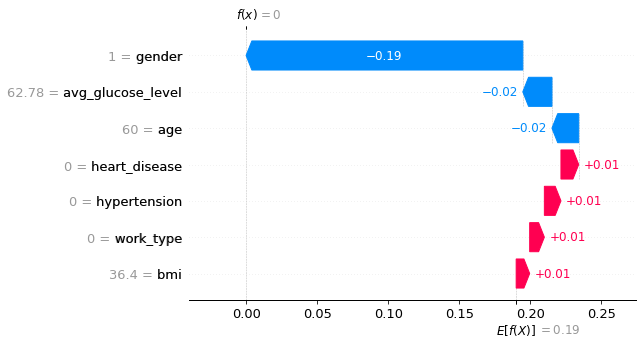

In [233]:
sample_feature_importance(12, 'waterfall')

Similarly this waterfall chart explains the contribution for the selected row and how different features are contributing to the baseline 0.

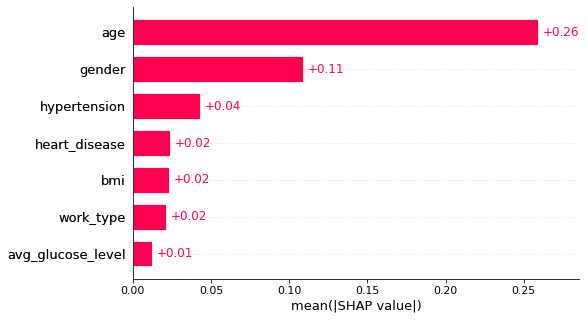

In [234]:
shap.plots.bar(shap_values)

#### Explaination for features for Logistic Regression model 
for the bar plot above:
The plot displays relative importance of the features.

Age is the most important, followed by gender, hypertension, heart_disease, bmi, work_type, avg_glucose_level.

These are absolute values hence does not show case to which direction the feature contributes to.

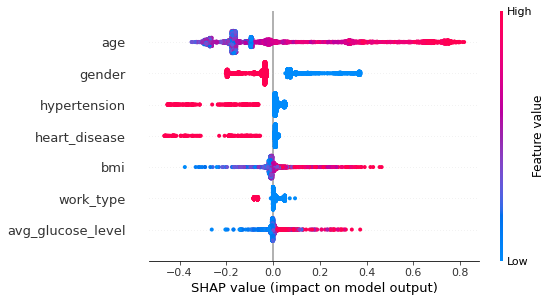

In [235]:
# load JS visualization code to notebook
shap.initjs()
shap.summary_plot(shap_values, X_test)


#### Explaination for summary plot for Logistic Regression model 
This is a summary plot which indicates the response wrt to different features. i.e. the more red the point is the more chance of suffering a stroke for that SHAP value for that feature.
Also, the features are in order of the importance of the variables, i..e Age is the most important feature.

As we can see higher the SHAP value of Age the more is the chance of suffering a stroke.

As the SHAP value of gender moves towards -0.2 the chances of stroke increases.

Similarly for other variables the effect can be obversed and infered for the above model.

In [263]:
def partial_dependence_plot_log(feature, idx=None):
    if idx is None: # visualize all samples
        shap.plots.partial_dependence(
            feature,
            logreg_pipeline.predict,
            X_train, 
            ice=False,
            model_expected_value=True, 
            feature_expected_value=True)
    else: # visualize sample idx
        shap.partial_dependence_plot(
            feature, 
            logreg_pipeline.predict,
            X_train, 
            ice=False,
            model_expected_value=True, 
            feature_expected_value=True,
            shap_values=shap_values[idx:idx+1,:])

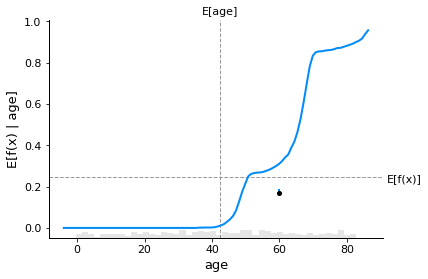

In [264]:
partial_dependence_plot_log('age', 12)

#### Explaination for partial dependance plot for age in logistic regression
The expected SHAP value suddenly increases for age around the age of 48 from 0 to 0.2 and after that keeps on increasing.


### Randomforest (Decision Tree)

In [170]:
# great resource: 
import shap  
#SHAP FOR RF
explainer = shap.TreeExplainer(rfc)

# calculate shap values. This is what we will plot.
shap_values = explainer.shap_values(X_test)


In [172]:
# Calculate Shap values
choosen_instance = X_test.loc[[12]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

#### Explaination for force plot for Decision Tree model 
for the force plot above:

all of the features (gender,age,avg_glucose_level etc) values lead to the prediction value of 0.53, which is then "transformed" to a value of 1. Here, by all values I mean even those that are not shown in the plot. However, Shap plots the top most influential features for the sample under study. Features in red color influence positively, i.e. drag the prediction value closer to 1, features in blue color - the opposite.

age in this case is 54 contributing to increase in the chance of a stroke and so is the work_type as private.

Similarly chances of stroke decreaase if a person is female and  bmi is 27.3.

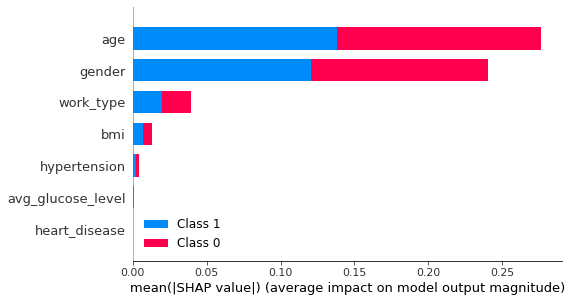

In [173]:
# load JS visualization code to notebook
shap.initjs()
shap.summary_plot(shap_values, X_test)


#### Explaination for features for Decision Tree model 
for the bar plot above:
The plot displays relative importance of the features and distribution of the sample as we used SMOTE to balance the dataset, the graph shows the same.

Age is the most important, followed by gender,work_type, bmi,hypertension,avg_glucose_level, heart_disease.

These are absolute values hence does not show case to which direction the feature contributes to.

  0%|          | 0/3577 [00:00<?, ?it/s]

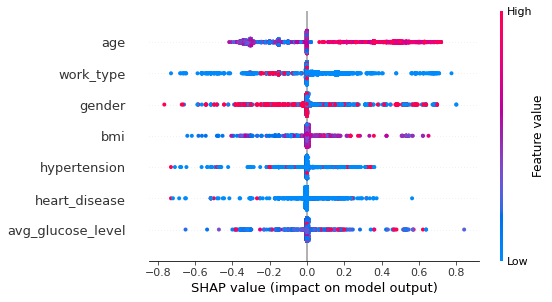

In [112]:
import shap
shap.initjs()
rf_shap_explainer = shap.KernelExplainer(rfc.predict,X_train)
rf2_shap_values = rf_shap_explainer.shap_values(X_test, nsamples=5)
shap.summary_plot(rf2_shap_values, X_test)


#### Explaination for summary plot for Decision Tree model 
This is a summary plot which indicates the response wrt to different features. i.e. the more red the point is the more chance of suffering a stroke for that SHAP value for that feature.
Also, the features are in order of the importance of the variables, i..e Age is the most important feature.

As we can see higher the SHAP value of Age the more is the chance of suffering a stroke.

As the SHAP value of work_type moves from -0.2 to -0.4 the chances of stroke increases.

Similarly for other variables the effect can be obversed and infered for the above model.

In [259]:
def partial_dependence_plot(feature, idx=None):
    if idx is None: # visualize all samples
        shap.plots.partial_dependence(
            feature,
            rfc.predict,
            X_train, 
            ice=False,
            model_expected_value=True, 
            feature_expected_value=True)
    else: # visualize sample idx
        shap.partial_dependence_plot(
            feature, 
            rfc.predict,
            X_train, 
            ice=False,
            model_expected_value=True, 
            feature_expected_value=True,
            shap_values=shap_values[idx:idx+1,:])

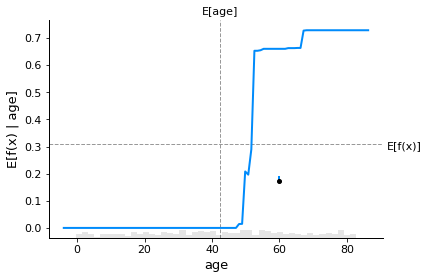

In [261]:
partial_dependence_plot('age', 12)

####Explaination for partial dependance plot for age in decision Tree model
The expected SHAP value suddenly increases for age around the age of 45 from 0 to 0.3 and after that there is a sudden increase till 52 and another surge in the SHAP value can seen after the age of 67 roughly.


### 3. AutoML  

In [190]:
explainer = shap.KernelExplainer(h2o_wrapper.predict_binary_prob, X_train.iloc[:100,:])
shap.initjs()
shap_values = explainer.shap_values(X_test.iloc[12,:], nsamples=500)
shap.force_plot(explainer.expected_value, shap_values, X_test.iloc[12,:])


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


#### Explaination for force plot for AutoML model 
for the force plot above:

all of the features (gender,age,avg_glucose_level etc) values lead to the prediction value of 0.03, which is then "transformed" to a value of 1. Here, by all values I mean even those that are not shown in the plot. However, Shap plots the top most influential features for the sample under study. Features in red color influence positively, i.e. drag the prediction value closer to 1, features in blue color - the opposite.

age in this case is 60 contributing to increase in the chance of a stroke.

Similarly chances of stroke decreaase if a person is female, avg_glucose_level, hypertension is 0, worktype is private.

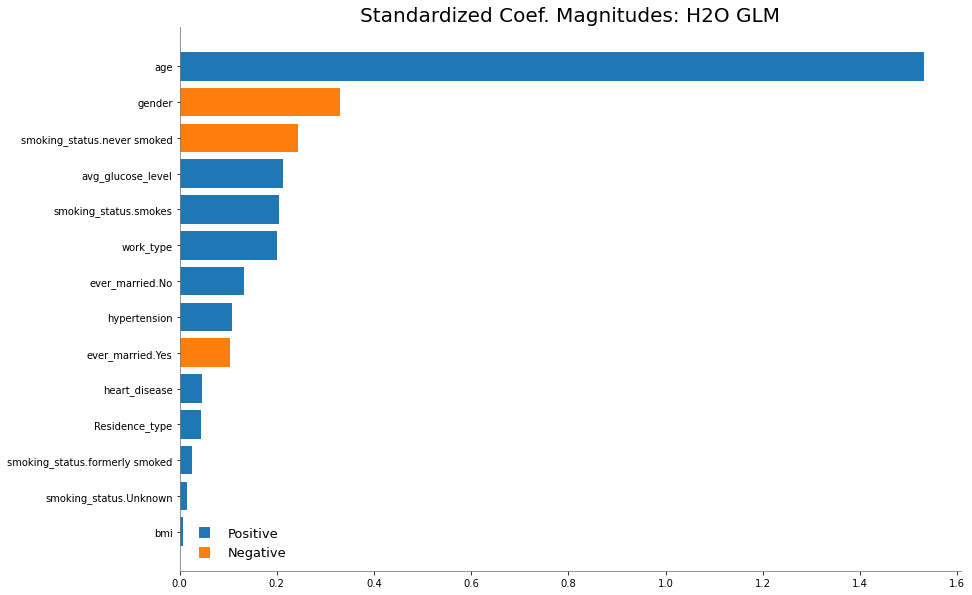

In [191]:
best_model.std_coef_plot()

#### Explaination for features for H2O AutoML model leader
for the bar plot above:
The plot displays relative importance of the features.

Age is the most important contributing positively towards having a stroke, followed by gender,smoking_status.never which contributes negatively.

Followed by avg_glucose_level,smoking_status, ever_married, hypertension which contribute towards having a stroke.

These are absolute values the color indicates to which direction the feature contributes to.

# Leaderboard

> Leaderboard shows models with their metrics and their predictions for a given row. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo,predict,p0,p1
GBM_4_AutoML_3_20221206_30846,0.888167,0.14938,0.268556,0.308287,0.196675,0.0386811,407,0.018184,GBM,0,0.923197,0.0768028
StackedEnsemble_BestOfFamily_1_AutoML_3_20221206_30846,0.886931,0.133679,0.200933,0.271676,0.191332,0.0366078,4081,0.027466,StackedEnsemble,1,0.873721,0.126279
StackedEnsemble_AllModels_1_AutoML_3_20221206_30846,0.886601,0.133949,0.201307,0.272356,0.191358,0.0366179,4917,0.026049,StackedEnsemble,1,0.873023,0.126977
GLM_1_AutoML_3_20221206_30846,0.8839,0.134288,0.204124,0.214286,0.191586,0.036705,220,0.009222,GLM,0,0.879652,0.120348
GBM_5_AutoML_3_20221206_30846,0.882375,0.13762,0.206622,0.283426,0.193307,0.0373677,282,0.019863,GBM,1,0.843844,0.156156
GBM_1_AutoML_3_20221206_30846,0.873469,0.138604,0.198212,0.272171,0.193898,0.0375963,455,0.017927,GBM,1,0.93713,0.0628698
GBM_2_AutoML_3_20221206_30846,0.871697,0.143265,0.231073,0.348299,0.194976,0.0380158,376,0.01614,GBM,1,0.890294,0.109706
XGBoost_grid_1_AutoML_3_20221206_30846_model_1,0.865471,0.138673,0.177202,0.273531,0.194539,0.0378456,331,0.010678,XGBoost,1,0.82124,0.17876
GBM_3_AutoML_3_20221206_30846,0.853845,0.148301,0.206745,0.268089,0.195645,0.0382769,353,0.017625,GBM,1,0.901383,0.0986172
XGBoost_1_AutoML_3_20221206_30846,0.837065,0.202849,0.198164,0.353061,0.246675,0.0608488,654,0.01538,XGBoost,0,0.399909,0.600091


# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

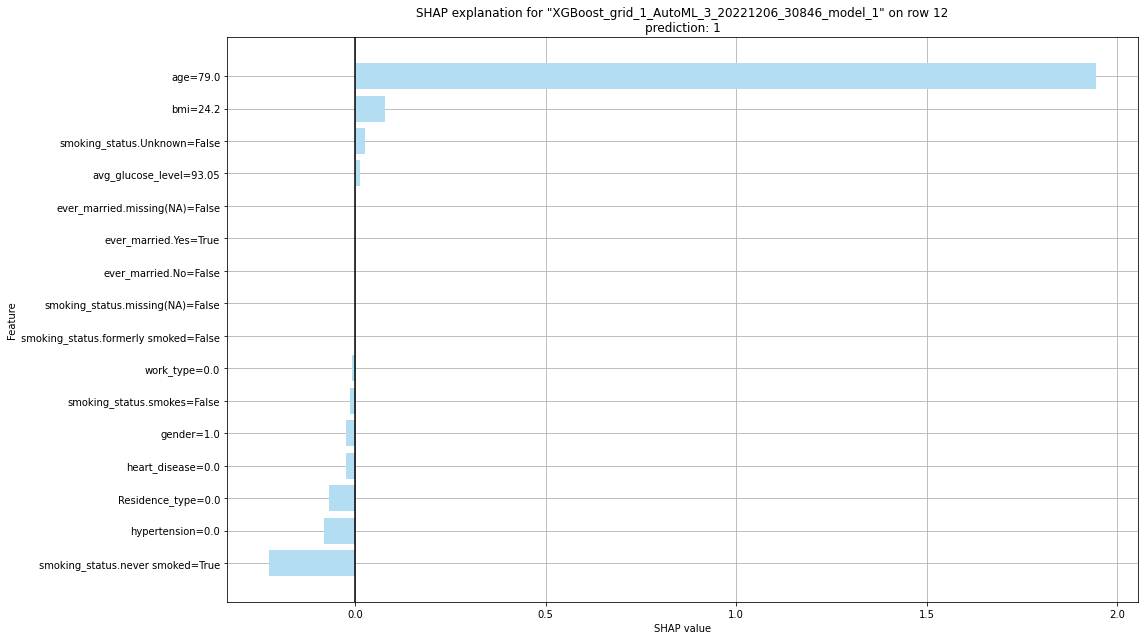

# Leaderboard

> Leaderboard shows models with their metrics and their predictions for a given row. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo,predict,p0,p1
GBM_4_AutoML_3_20221206_30846,0.888167,0.14938,0.268556,0.308287,0.196675,0.0386811,407,0.018184,GBM,0,0.923197,0.0768028
StackedEnsemble_BestOfFamily_1_AutoML_3_20221206_30846,0.886931,0.133679,0.200933,0.271676,0.191332,0.0366078,4081,0.027466,StackedEnsemble,1,0.873721,0.126279
StackedEnsemble_AllModels_1_AutoML_3_20221206_30846,0.886601,0.133949,0.201307,0.272356,0.191358,0.0366179,4917,0.026049,StackedEnsemble,1,0.873023,0.126977
GLM_1_AutoML_3_20221206_30846,0.8839,0.134288,0.204124,0.214286,0.191586,0.036705,220,0.009222,GLM,0,0.879652,0.120348
GBM_5_AutoML_3_20221206_30846,0.882375,0.13762,0.206622,0.283426,0.193307,0.0373677,282,0.019863,GBM,1,0.843844,0.156156
GBM_1_AutoML_3_20221206_30846,0.873469,0.138604,0.198212,0.272171,0.193898,0.0375963,455,0.017927,GBM,1,0.93713,0.0628698
GBM_2_AutoML_3_20221206_30846,0.871697,0.143265,0.231073,0.348299,0.194976,0.0380158,376,0.01614,GBM,1,0.890294,0.109706
XGBoost_grid_1_AutoML_3_20221206_30846_model_1,0.865471,0.138673,0.177202,0.273531,0.194539,0.0378456,331,0.010678,XGBoost,1,0.82124,0.17876
GBM_3_AutoML_3_20221206_30846,0.853845,0.148301,0.206745,0.268089,0.195645,0.0382769,353,0.017625,GBM,1,0.901383,0.0986172
XGBoost_1_AutoML_3_20221206_30846,0.837065,0.202849,0.198164,0.353061,0.246675,0.0608488,654,0.01538,XGBoost,0,0.399909,0.600091


# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

In [192]:
aml.explain_row(test,row_index=12)

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
GBM_4_AutoML_3_20221206_30846,0.888167,0.14938,0.268556,0.308287,0.196675,0.0386811,407,0.018184,GBM
StackedEnsemble_BestOfFamily_1_AutoML_3_20221206_30846,0.886931,0.133679,0.200933,0.271676,0.191332,0.0366078,4081,0.027466,StackedEnsemble
StackedEnsemble_AllModels_1_AutoML_3_20221206_30846,0.886601,0.133949,0.201307,0.272356,0.191358,0.0366179,4917,0.026049,StackedEnsemble
GLM_1_AutoML_3_20221206_30846,0.8839,0.134288,0.204124,0.214286,0.191586,0.036705,220,0.009222,GLM
GBM_5_AutoML_3_20221206_30846,0.882375,0.13762,0.206622,0.283426,0.193307,0.0373677,282,0.019863,GBM
GBM_1_AutoML_3_20221206_30846,0.873469,0.138604,0.198212,0.272171,0.193898,0.0375963,455,0.017927,GBM
GBM_2_AutoML_3_20221206_30846,0.871697,0.143265,0.231073,0.348299,0.194976,0.0380158,376,0.01614,GBM
XGBoost_grid_1_AutoML_3_20221206_30846_model_1,0.865471,0.138673,0.177202,0.273531,0.194539,0.0378456,331,0.010678,XGBoost
GBM_3_AutoML_3_20221206_30846,0.853845,0.148301,0.206745,0.268089,0.195645,0.0382769,353,0.017625,GBM
XGBoost_1_AutoML_3_20221206_30846,0.837065,0.202849,0.198164,0.353061,0.246675,0.0608488,654,0.01538,XGBoost


# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## GLM_1_AutoML_3_20221206_30846

,0,1,Error,Rate
0,665.0,70.0,0.0952,(70.0/735.0)
1,11.0,22.0,0.3333,(11.0/33.0)
Total,676.0,92.0,0.1055,(81.0/768.0)


# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

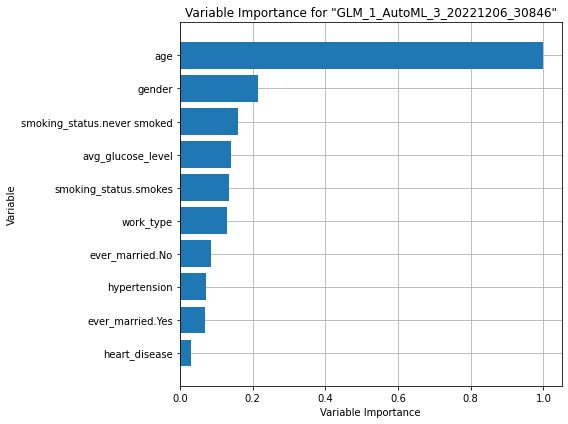

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

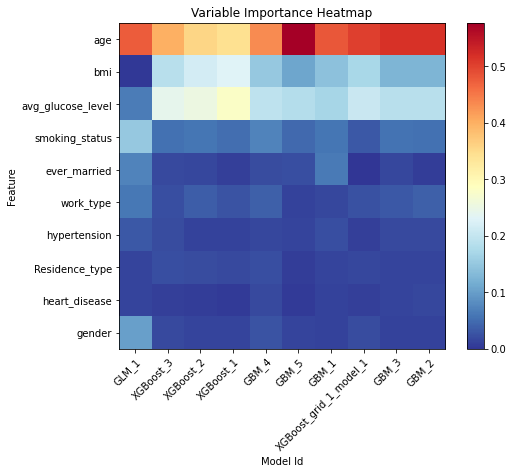

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

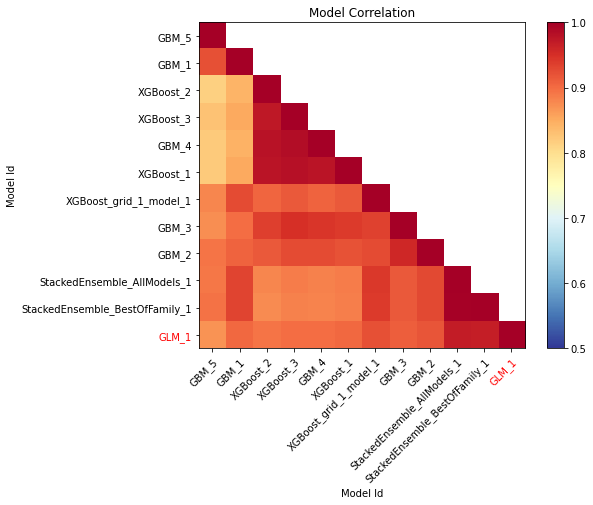

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

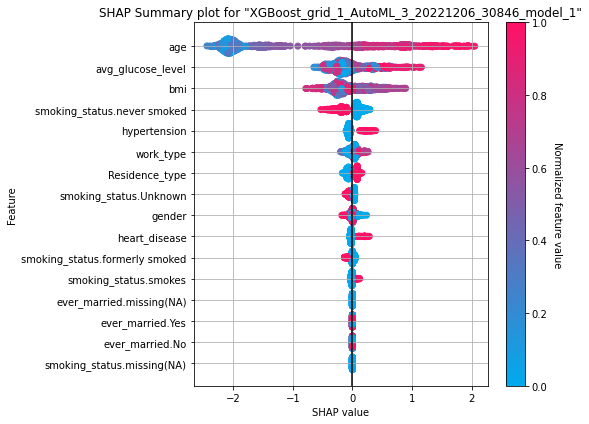

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

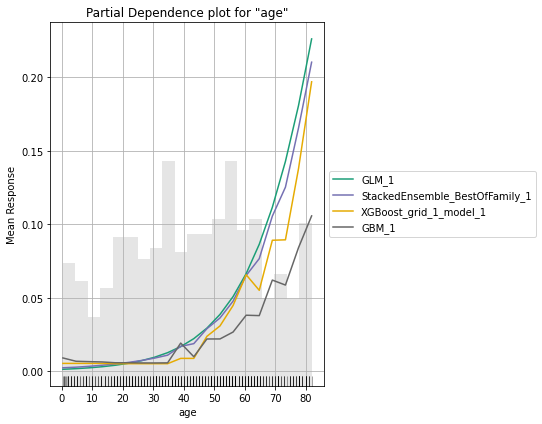

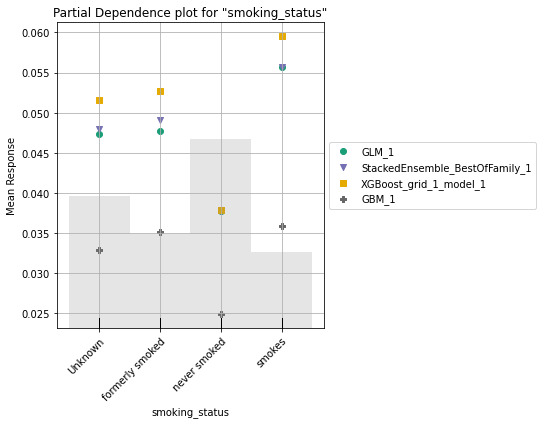

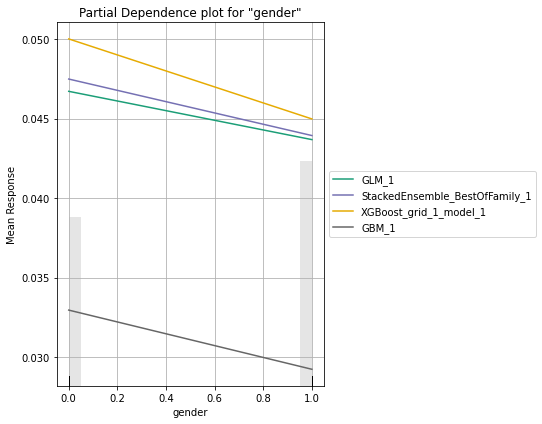

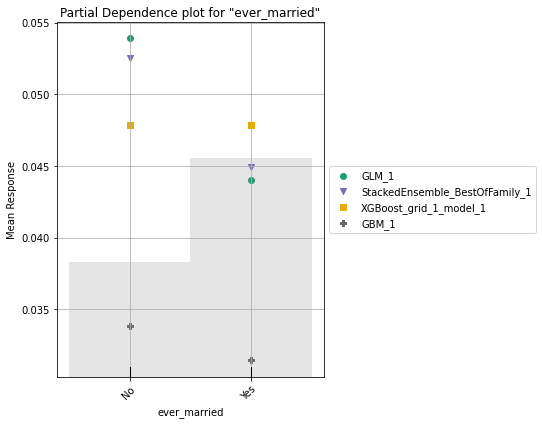

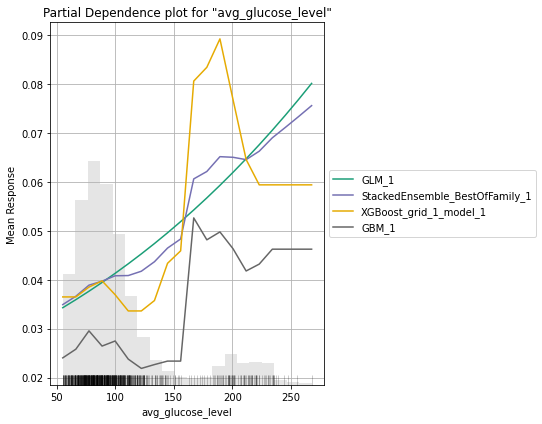

In [193]:
explain_model = aml.explain(frame = test, figsize = (8,6))

#### Explaination for summary plot for H2O AutoML best model 
From the 2 graphs above [SHAP summary and SHAP explanation]

This is a summary plot which indicates the response wrt to different features. i.e. the more red the point is the more chance of suffering a stroke for that SHAP value for that feature.
Also, the features are in order of the importance of the variables, i..e Age is the most important feature.

As we can see higher the SHAP value of Age the more is the chance of suffering a stroke.

As the SHAP value of gender moves towards 0.2 the chances of stroke increases.

Similarly for other variables the effect can be obversed and infered for the above model.

####Explaination for partial dependance plot for age in H2OAutoML model
The expected SHAP value suddenly increases like a quadratic equation for age around the age of 50 from 0 to 0.05 and after that there is a increase till the age 80 the shap values go till 0.3.

If we observe the partial dependance plot for age we can see that the risk of getting a stroke is increasing similar to a quadratic equation as the age increases.

# Conclusion

We started by exploring our data and noticed that certain features, such as Age, looked to be good indicators for predicting a stroke.

After extensive visualization, we went on to try multiple models.

Logistic Regression,Random Forest and H2OAutoML (GLM) were all tried and based on the performance metrics and feature importance we can say that H2OAutoML performed the best with highest AUC.

AUC for Logistic Regression:0.67

AUC for RandomForest (decision Tree): 0.70

AUC for H2OAutoML(GLM): 0.88

The advantage of using SHAP for all the 3 models above are:
1. that it gives the relative importance of variables for each model, which helps us realize the contribution of each variable. For example: the importance of age is considered most appropriately while using AutoML.
2. It lets us visualize each sample and how its predicted values are effected due to various predictors.
3. It summarizes the data in a visual manner which is easy to interpret and helps to make informed decisions while considering different predictors and approaches.


# References
1. [Kaggle Notebook for advance use of SHAP values](https://www.kaggle.com/code/dansbecker/advanced-uses-of-shap-values/tutorial)
2. [SHAP Documentation](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.summary_plot.html)
3. [Intro to h2o](https://github.com/aiskunks/Skunks_Skool/blob/main/INFO_6105/6105/intro-to-h2o.ipynb)
4. [A Deep dive into H2O’s AutoML](https://towardsdatascience.com/a-deep-dive-into-h2os-automl-4b1fe51d3f3e)
5. [SKlearn Documentaion](https://scikit-learn.org/)
6. [SHAP usecase Reference Notebook](https://github.com/ajhalthor/model-interpretability/blob/main/Shap%20Values.ipynb)

7. [SHAP Plots Help](https://www.kaggle.com/code/ritzig/classification-feature-selection-shap-tutorial#SHAP)



Copyright 2022 *Akhilesh Dongre*

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.